### On May 15, 2024, Ubisoft presented a trailer for a new game in the Assassin's Creed franchise. As of June 26, 2024, the trailer had collected almost 9 million views and almost 90 thousand comments and was received ambiguously by the audience. Therefore, it would be interesting to study the reaction of viewers using NLP methods. 

### Setup 

In [24]:
pip install --upgrade translators

     ---------------------------------------- 0.0/68.8 kB ? eta -:--:--
     ---------------------------------------- 68.8/68.8 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.4 kB ? eta -:--:--
   ---------------------------------------- 56.4/56.4 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ------ --------------------------------- 0.4/2.9 MB 13.4 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.9 MB 13.1 MB/s eta 0:0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import translators as ts


### Download data from Youtube using Google Youtube API

In [11]:
# -*- coding: utf-8 -*-

import os
import googleapiclient.discovery
import csv

DEVELOPER_KEY = "INSERT_YOUR_DEV_KEY"
VIDEO_ID = "vovkzbtYBC8"

# Function to download top-level comments
def youtube(nextPageToken=None):
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"    

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=DEVELOPER_KEY)

    request = youtube.commentThreads().list(
        part="id,snippet",
        maxResults=100,
        pageToken=nextPageToken,
        videoId=VIDEO_ID
    )
    response = request.execute()
    return response

# Function to download replies to comments
def youtubechild(NextParentId, nextPageToken=None):
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=DEVELOPER_KEY)

    request = youtube.comments().list(
        part="id,snippet",
        maxResults=100,
        pageToken=nextPageToken,
        parentId=NextParentId
    )
    response = request.execute()
    return response

# Main function
def main():
    # Download comments
    print('Downloading comments')
    response = youtube()
    items = response.get("items")
    nextPageToken = response.get("nextPageToken")  # downloaded in portions, each next portion is indicated by a token
    i = 1
    while nextPageToken is not None:
        print(str(i * 100))  # display which hundred comments are being downloaded
        response = youtube(nextPageToken)
        nextPageToken = response.get("nextPageToken")
        items = items + response.get("items")
        i += 1

    print(len(items))  # Display the number of downloaded comments

    # Download replies to comments
    print('Downloading replies')
    replies = []
    for line in items:  # Loop through top-level comments
        if line.get("snippet").get("totalReplyCount") > 0:  # if there are replies
            print(line.get("snippet").get("totalReplyCount"))  # display how many replies will be downloaded
            response = youtubechild(line.get("snippet").get("topLevelComment").get("id"))
            replies = replies + response.get("items")
            nextPageToken = response.get("nextPageToken")
            i = 1
            while nextPageToken is not None:  # load more replies if there are more portions
                response = youtubechild(line.get("snippet").get("topLevelComment").get("id"), nextPageToken)
                nextPageToken = response.get("nextPageToken")
                replies = replies + response.get("items")
                i += 1

    print(len(replies))  # Display the number of downloaded replies

    # Save comments and replies to a CSV file
    print("Opening CSV file")
    with open('youtuberesults.csv', 'w', encoding="utf-8") as csv_file:  # with statement to automatically close the file after all commands
        writer = csv.writer(csv_file, quoting=csv.QUOTE_ALL, lineterminator='\r')  # using double quotes and comma separator, this format opens well in LibreOffice Calc

        # Column headers
        row = [
            'etag',
            'parentid',
            'id',
            'textDisplay',
            'textOriginal',
            'authorDisplayName',
            'authorProfileImageUrl',
            'authorChannelUrl',
            'authorChannelId',
            'likeCount',
            'publishedAt',
            'updatedAt'
        ]
        print("Starting to write to CSV")  
        writer.writerow(row)  # Write headers to the file
    
        # Save comments
        print("Writing comments to CSV")  
        for line in items:
            topLevelComment = line.get("snippet").get("topLevelComment")
            # sometimes the user does not have a channel, so a separate construction for that
            if topLevelComment.get('snippet').get('authorChannelId') is not None:
                authorChannelId = topLevelComment.get('snippet').get('authorChannelId').get('value')
            else:
                authorChannelId = ''
            row = [
                topLevelComment.get('etag'),
                topLevelComment.get('id'),
                topLevelComment.get('id'),
                topLevelComment.get('snippet').get('textDisplay'),
                topLevelComment.get('snippet').get('textOriginal'),
                topLevelComment.get('snippet').get('authorDisplayName'),
                topLevelComment.get('snippet').get('authorProfileImageUrl'),
                topLevelComment.get('snippet').get('authorChannelUrl'),
                authorChannelId,
                topLevelComment.get('snippet').get('likeCount'),
                topLevelComment.get('snippet').get('publishedAt'),
                topLevelComment.get('snippet').get('updatedAt')
            ]
            writer.writerow(row)

        # Save replies
        print("Writing replies to CSV")  
        for line in replies:
            # sometimes the user does not have a channel, so a separate construction for that
            if line.get('snippet').get('authorChannelId') is not None:
                authorChannelId = line.get('snippet').get('authorChannelId').get('value')
            else:
                authorChannelId = ''
            row = [
                line.get('etag'),
                line.get('snippet').get('parentId'),
                line.get('id'),
                line.get('snippet').get('textDisplay'),
                line.get('snippet').get('textOriginal'),
                line.get('snippet').get('authorDisplayName'),
                line.get('snippet').get('authorProfileImageUrl'),
                line.get('snippet').get('authorChannelUrl'),
                authorChannelId,
                line.get('snippet').get('likeCount'),
                line.get('snippet').get('publishedAt'),
                line.get('snippet').get('updatedAt')
            ]
            writer.writerow(row)
        
    print("Done")  

if __name__ == "__main__":
    main()

download comments
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
1820

### Data reading

In [4]:
df = pd.read_csv("youtuberesults.csv")

In [5]:
df.head()

,etag,parentid,id,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,likeCount,publishedAt,updatedAt
0,8afBP0g4q1VdlfL9v9qhQh5XKS0,Ugyrih7ysCq7xMawUeN4AaABAg,Ugyrih7ysCq7xMawUeN4AaABAg,Was wondering if I’m still watching an assassi...,Was wondering if I’m still watching an assassi...,@yeliseyshitik2767,https://yt3.ggpht.com/ytc/AIdro_kHr5RBTLXjqpn7...,http://www.youtube.com/@yeliseyshitik2767,UC1dFzRmJaVwejnnGVFeoQlA,0,2024-06-23T21:29:51Z,2024-06-23T21:29:51Z
1,-OveCdhEp9zYXr0zZD2wLVMdq6I,UgzJ_zwWiX3OfhTyIDh4AaABAg,UgzJ_zwWiX3OfhTyIDh4AaABAg,I really hope they redo the music to something...,I really hope they redo the music to something...,@thelayedbackguitarist9865,https://yt3.ggpht.com/wuqdVKt_NQAl1KX4139171Vv...,http://www.youtube.com/@thelayedbackguitarist9865,UC3UjnwqU2pf8WzLZ6J2vQhw,0,2024-06-23T20:29:53Z,2024-06-23T20:29:53Z
2,Saf0SdP2eTWJEVROFiHgNvTyutk,UgzU6yRCDy3f1YD9tvB4AaABAg,UgzU6yRCDy3f1YD9tvB4AaABAg,"At the end of the day, people down playing thi...","At the end of the day, people down playing thi...",@AmalaSounds,https://yt3.ggpht.com/PLb_K0I7U3DpTmOJBb5O9FWL...,http://www.youtube.com/@AmalaSounds,UCgD04o8XHpvs7rJkQP55bRA,0,2024-06-23T19:53:39Z,2024-06-23T19:53:39Z
3,Z5lSIagdBXVSGUEsEND0NiKvJ5o,UgzlUNdHg2R7uOGtFC54AaABAg,UgzlUNdHg2R7uOGtFC54AaABAg,I&#39;m a big fan of Ghost of Tsushima and I&#...,I'm a big fan of Ghost of Tsushima and I'm sti...,@AmalaSounds,https://yt3.ggpht.com/PLb_K0I7U3DpTmOJBb5O9FWL...,http://www.youtube.com/@AmalaSounds,UCgD04o8XHpvs7rJkQP55bRA,1,2024-06-23T19:44:49Z,2024-06-23T19:44:49Z
4,PlNOJm618_LVrdYTKZ4toYop4Xk,UgwypAi0WICQlskf8LR4AaABAg,UgwypAi0WICQlskf8LR4AaABAg,I don&#39;t know why but this game reminds a l...,I don't know why but this game reminds a littl...,@Hacker65555,https://yt3.ggpht.com/JfdvOKNBah9LHLbCummaVdCc...,http://www.youtube.com/@Hacker65555,UC8EVbw6ZgrLRneVzFbx3tAQ,0,2024-06-23T17:28:47Z,2024-06-23T17:32:31Z


In [6]:
df_text = df[['textDisplay', 'textOriginal', 'authorDisplayName', 'likeCount', 'publishedAt']]

In [7]:
df_text.head()

,textDisplay,textOriginal,authorDisplayName,likeCount,publishedAt
0,Was wondering if I’m still watching an assassi...,Was wondering if I’m still watching an assassi...,@yeliseyshitik2767,0,2024-06-23T21:29:51Z
1,I really hope they redo the music to something...,I really hope they redo the music to something...,@thelayedbackguitarist9865,0,2024-06-23T20:29:53Z
2,"At the end of the day, people down playing thi...","At the end of the day, people down playing thi...",@AmalaSounds,0,2024-06-23T19:53:39Z
3,I&#39;m a big fan of Ghost of Tsushima and I&#...,I'm a big fan of Ghost of Tsushima and I'm sti...,@AmalaSounds,1,2024-06-23T19:44:49Z
4,I don&#39;t know why but this game reminds a l...,I don't know why but this game reminds a littl...,@Hacker65555,0,2024-06-23T17:28:47Z


### Date extraction

In [8]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

In [9]:
df['date'] = df['publishedAt'].dt.date

In [11]:
comment_counts = df['date'].value_counts().sort_index()

In [12]:
print(comment_counts)

date
2024-05-13      463
2024-05-14      538
2024-05-15    34112
2024-05-16    19639
2024-05-17     8901
2024-05-18     5994
2024-05-19     3550
2024-05-20     2988
2024-05-21     2276
2024-05-22     1896
2024-05-23     1540
2024-05-24     1071
2024-05-25      829
2024-05-26      613
2024-05-27      515
2024-05-28      468
2024-05-29      439
2024-05-30      337
2024-05-31      327
2024-06-01      218
2024-06-02      209
2024-06-03      221
2024-06-04      194
2024-06-05      150
2024-06-06      115
2024-06-07       75
2024-06-08      157
2024-06-09      134
2024-06-10      102
2024-06-11      109
2024-06-12      135
2024-06-13      117
2024-06-14      113
2024-06-15      115
2024-06-16       96
2024-06-17      121
2024-06-18      130
2024-06-19       75
2024-06-20      181
2024-06-21      117
2024-06-22       61
2024-06-23       73
Name: count, dtype: int64


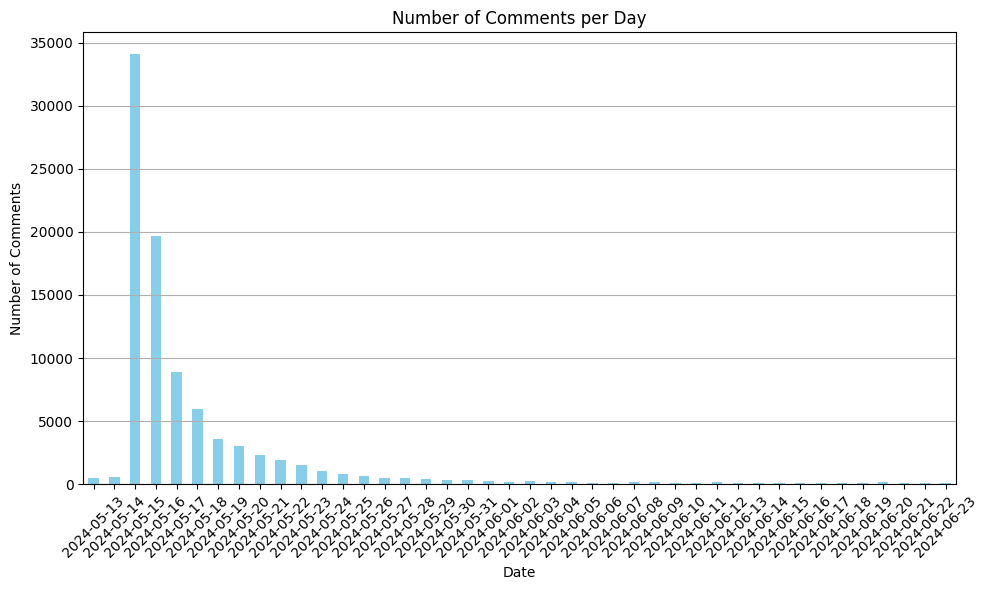

In [14]:
plt.figure(figsize=(10, 6))
comment_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Comments per Day')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

The graph shows that the number of comments decreases over time. This is quite natural. We can also notice data for May 13th and 14th. This is very strange, because the video premiered on May 15th. Let's take a look at the data for May 13th and 14th

In [17]:
filtered_df = df[df['date'].isin([pd.to_datetime('2024-05-13').date(), pd.to_datetime('2024-05-14').date()])]

In [19]:
filtered_df.head(10)

,etag,parentid,id,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,likeCount,publishedAt,updatedAt,date
46848,KR5YF8fMs47D6xt60yKbGHz1eXU,Ugw32wWmJQlRq-dGb114AaABAg,Ugw32wWmJQlRq-dGb114AaABAg,Unity was the peak. Can ubislop even match the...,Unity was the peak. Can ubislop even match the...,@lte6983,https://yt3.ggpht.com/CQDzPdjE4NlObMOlpmGtuDkI...,http://www.youtube.com/@lte6983,UCET4rPgzlah0ANje0UOCgSg,0,2024-05-14 23:55:46+00:00,2024-05-14T23:55:46Z,2024-05-14
46849,8xsjgwJ2NZWAB8W0w1kIPnvGGhE,Ugwab7rz8TBSfLcYcyl4AaABAg,Ugwab7rz8TBSfLcYcyl4AaABAg,After AC valhalla how big the story and map be...,After AC valhalla how big the story and map be...,@alaaramadan8618,https://yt3.ggpht.com/y6OqZt4QzbnziRVnBPqPbSvv...,http://www.youtube.com/@alaaramadan8618,UC3XTNrVCz7LORX1s5FYfz5Q,0,2024-05-14 23:51:04+00:00,2024-05-14T23:51:04Z,2024-05-14
46850,HLy61ccHpWlozhzDtz22EJRGhuI,Ugwaf7KwA-7Xa9w2cn94AaABAg,Ugwaf7KwA-7Xa9w2cn94AaABAg,Ya mero!!,Ya mero!!,@AngelGarcia-mq1cf,https://yt3.ggpht.com/ytc/AIdro_mGdticK92S3eRe...,http://www.youtube.com/@AngelGarcia-mq1cf,UCIXWmvj8ifu0lHnJ62LmbJQ,1,2024-05-14 23:48:37+00:00,2024-05-14T23:48:37Z,2024-05-14
46851,wIpCRSzTAZkxO9bMlUn6A1ikHoA,UgzWixXRf5W6Lrpwe314AaABAg,UgzWixXRf5W6Lrpwe314AaABAg,Dont get your hopes up. Its gonna be just like...,Dont get your hopes up. Its gonna be just like...,@whiteeagleforce2.040,https://yt3.ggpht.com/PpUYpRDRB_ep9v1_Gwiht9zq...,http://www.youtube.com/@whiteeagleforce2.040,UCBqhULiMXCVAEK1uAPLgfGQ,0,2024-05-14 23:45:21+00:00,2024-05-14T23:45:21Z,2024-05-14
46852,G6Fdsmv0ejGFt3aqxswiSs30V_4,UgyBeaBnzJR0ujkk67F4AaABAg,UgyBeaBnzJR0ujkk67F4AaABAg,Can&#39;t waaaaaaiiiiittttttt!,Can't waaaaaaiiiiittttttt!,@Nyx47593,https://yt3.ggpht.com/ytc/AIdro_kxPpXHhfmhua7x...,http://www.youtube.com/@Nyx47593,UCGzr8p9Ux7GShWV6HbArVQQ,0,2024-05-14 23:42:58+00:00,2024-05-14T23:42:58Z,2024-05-14
46853,u8Ntisbc0MjQhkm-1cCnxOb0ynk,UgxVV9aTnwX4-0LavEx4AaABAg,UgxVV9aTnwX4-0LavEx4AaABAg,El PSOE NOS FUMIGA,El PSOE NOS FUMIGA,@user-dh1bf2vr9r,https://yt3.ggpht.com/ytc/AIdro_lf4rKMSD4tgPnv...,http://www.youtube.com/@user-dh1bf2vr9r,UCzbVItvFYiHntscAwC7503Q,0,2024-05-14 23:41:23+00:00,2024-05-14T23:41:23Z,2024-05-14
46854,WrpYNvgJhFKmFvodHaRdIl_Tv2E,UgxHl8Py5ihh0NcMI1B4AaABAg,UgxHl8Py5ihh0NcMI1B4AaABAg,Let&#39;s see what this is all about.,Let's see what this is all about.,@1lham_edits,https://yt3.ggpht.com/ttR-sZUCtHu2OtLXFUFZ0mPS...,http://www.youtube.com/@1lham_edits,UCkCLLUmvljPsI62b4GGK4tw,0,2024-05-14 23:39:20+00:00,2024-05-14T23:39:20Z,2024-05-14
46855,6AN9ii3K_ggZ7vzOWWAeHpcIPyE,UgzxxDjBB0Ka5Ut6YQp4AaABAg,UgzxxDjBB0Ka5Ut6YQp4AaABAg,Ghost of Tsus- uh I mean “Assassins Creed: Sha...,Ghost of Tsus- uh I mean “Assassins Creed: Sha...,@raptorbrotherhood766,https://yt3.ggpht.com/ytc/AIdro_k-GlCELCqHMIZq...,http://www.youtube.com/@raptorbrotherhood766,UCx_1LCofUfOrr28kmy4FpwQ,0,2024-05-14 23:32:31+00:00,2024-05-14T23:32:31Z,2024-05-14
46856,CQOKjAYKyD7dbGcAVyMa1nzGMbE,UgwKV-jVBynjuYO8Bt14AaABAg,UgwKV-jVBynjuYO8Bt14AaABAg,It&#39;s vampire assassin we know it already,It's vampire assassin we know it already,@liviuuzuma9296,https://yt3.ggpht.com/mlh_tDvrW6uma9f84GGPh8Ze...,http://www.youtube.com/@liviuuzuma9296,UCcqqFBq1uErMIO5fElnsf4g,0,2024-05-14 23:26:36+00:00,2024-05-14T23:26:36Z,2024-05-14
46857,F_O5Hcu39ZIKl5VYJauXWHuJXh8,Ugz_D-F3B-7rXo8MCKR4AaABAg,Ugz_D-F3B-7rXo8MCKR4AaABAg,AC1からミラージュまでプレイしてきた日本人として、このゲームが素晴らしいクオリティであるこ...,AC1からミラージュまでプレイしてきた日本人として、このゲームが素晴らしいクオリティであるこ...,@shoukan3,https://yt3.ggpht.com/GvtPzdQpZiaYFJRGBl1xEMIZ...,http://www.youtube.com/@shoukan3,UCigkiTxGtNkmMe4T-OtQr-g,0,2024-05-14 23:25:56+00:00,2024-05-14T23:25:56Z,2024-05-14


These comments seem normal enough. 
</p>Perhaps this trailer was in the public domain or this is due to the specifics of Youtube's work.

### Data translation 

As we can see, the comments are written in different languages. Let's translate them into English

In [26]:
# Translate comments to English
def translate_comment(text):
    try:
        return ts.google(text, from_language='auto', to_language='en')
    except Exception as e:
        return text  # Return the original text if translation fails

In [27]:
filtered_df['textOriginalTranslated'] = filtered_df['textOriginal'].apply(translate_comment)

C:\Users\nik-g\AppData\Local\Temp\ipykernel_14208\3543089643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['textOriginalTranslated'] = filtered_df['textOriginal'].apply(translate_comment)
